In [1]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
df_juliet = pd.read_csv('/content/drive/My Drive/juliet.csv')

In [4]:
df_natural = pd.read_csv('/content/drive/My Drive/real-world.csv')

In [5]:
df_true = df_juliet[df_juliet['is_vuln'] == True].sample(n=30000, random_state=42)
df_false = df_juliet[df_juliet['is_vuln'] == False].sample(n=30000, random_state=42)

df_test_juliet = pd.concat([df_true, df_false]).reset_index(drop=True)

In [43]:
df_test_juliet_subset = df_test_juliet[['function_code_generic', 'is_vuln']].copy()
df_test_juliet_subset.columns = ['func', 'target']

df_test_natural_subset = df_natural[['func', 'target']].copy()

df_test = pd.concat([df_test_juliet_subset, df_test_natural_subset], ignore_index=True)

In [44]:
print(df_test.shape)

(115311, 2)


In [45]:
import re

def remove_comments_from_func_column(df, column_name='func'):
    def clean_code(code):
        if not isinstance(code, str):
            return ''
        code = re.sub(r'//.*?$|#.*?$', '', code, flags=re.MULTILINE)
        code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
        code = re.sub(r'[^\w\s]', ' ', code)
        code = re.sub(r'\s+', ' ', code)
        return code.strip().lower()

    df_cleaned = df.copy()
    df_cleaned[column_name] = df_cleaned[column_name].apply(clean_code)
    return df_cleaned

In [46]:
df_test_juliet_subset_cleaned = remove_comments_from_func_column(df_test_juliet_subset)
df_test_natural_subset_cleaned = remove_comments_from_func_column(df_test_natural_subset)
df_test_cleaned = remove_comments_from_func_column(df_test)

In [47]:
print(df_test_cleaned['func'][0])

void function int data data 1 wsadata wsadata int wsadatainit 0 int recvresult struct sockaddr_in service socket connectsocket invalid_socket char inputbuffer char_array_size do if wsastartup makeword 2 2 wsadata no_error break wsadatainit 1 connectsocket socket af_inet sock_stream ipproto_tcp if connectsocket invalid_socket break memset service 0 sizeof service service sin_family af_inet service sin_addr s_addr inet_addr ip_address service sin_port htons tcp_port if connect connectsocket struct sockaddr service sizeof service socket_error break recvresult recv connectsocket inputbuffer char_array_size 1 0 if recvresult socket_error recvresult 0 break inputbuffer recvresult 0 data atoi inputbuffer while 0 if connectsocket invalid_socket close_socket connectsocket if wsadatainit wsacleanup cwe122_heap_based_buffer_overflow__c_cwe129_connect_socket_52b_badsink data


In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

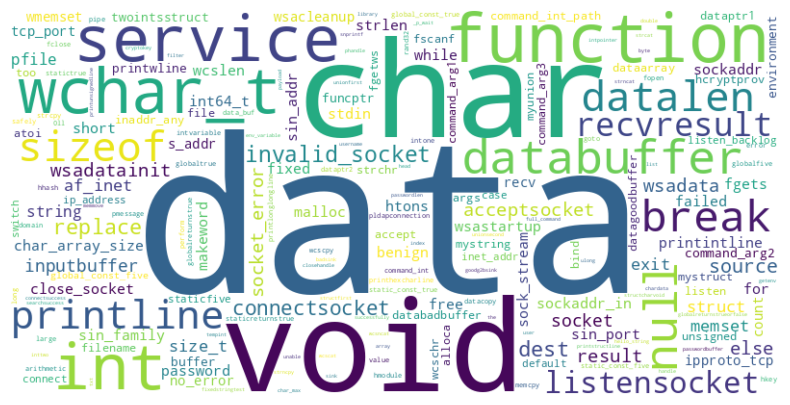

In [50]:
text = ' '.join(df_test_juliet_subset_cleaned['func'].dropna().astype(str))
words = [word for word in text.split() if len(word) > 2 and not word.isnumeric()]
word_counts = Counter(words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

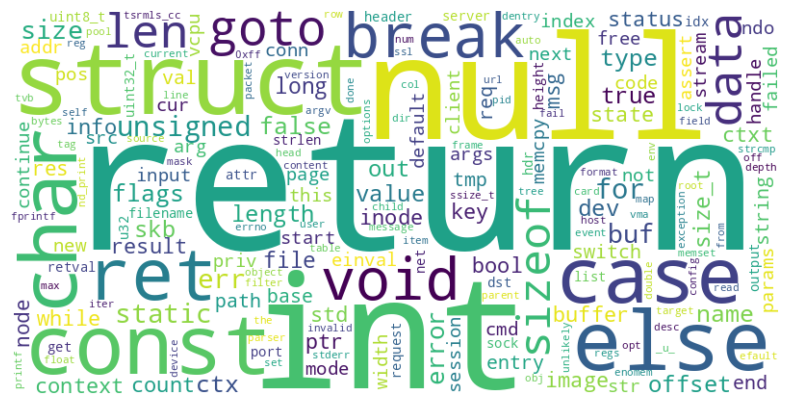

In [51]:
text = ' '.join(df_test_natural_subset_cleaned['func'].dropna().astype(str))
words = [word for word in text.split() if len(word) > 2 and not word.isnumeric()]
word_counts = Counter(words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

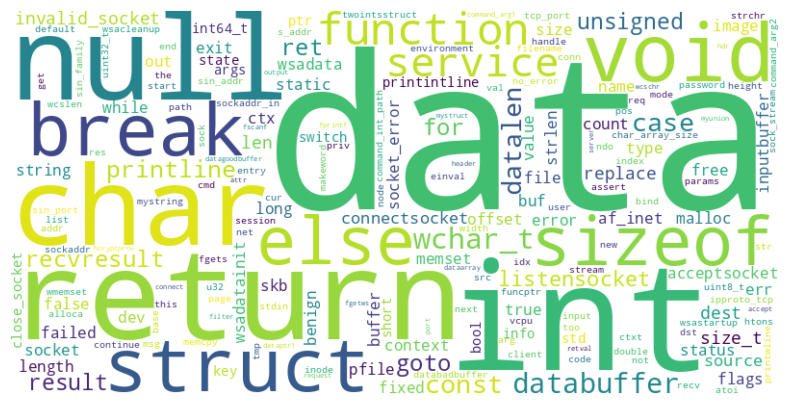

In [52]:
text = ' '.join(df_test_cleaned['func'].dropna().astype(str))
words = [word for word in text.split() if len(word) > 2 and not word.isnumeric()]
word_counts = Counter(words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [53]:
import pandas as pd
import re

def extract_code_features(df, column='func'):
    def compute_features(code):
        if not isinstance(code, str):
            return {
                'num_lines': 0,
                'average_line_length': 0,
                'cyclomatic_complexity': 1,
                'num_chars': 0,
                'num_tokens': 0,
                'average_token_length': 0
            }

        lines = code.strip().split('\n')
        num_lines = len(lines)
        line_lengths = [len(line.strip()) for line in lines]
        average_line_length = sum(line_lengths) / num_lines if num_lines > 0 else 0
        num_chars = sum(line_lengths)

        tokens = re.findall(r'\b\w+\b', code)
        num_tokens = len(tokens)
        average_token_length = num_chars / num_tokens if num_tokens > 0 else 0

        complexity_keywords = ['if', 'for', 'while', 'case', '&&', '||', '?', 'else if']
        complexity = 1 + sum(len(re.findall(r'\b' + re.escape(k) + r'\b', code)) for k in complexity_keywords)

        return {
            'num_lines': num_lines,
            'average_line_length': average_line_length,
            'cyclomatic_complexity': complexity,
            'num_chars': num_chars,
            'num_tokens': num_tokens,
            'average_token_length': average_token_length
        }

    feature_df = df.copy()
    features = feature_df[column].apply(compute_features).apply(pd.Series)
    return pd.concat([feature_df, features], axis=1)

In [55]:
df_test_features = extract_code_features(df_test)
df_natural_features = extract_code_features(df_test_natural_subset)
df_juliet_features = extract_code_features(df_test_juliet_subset)

In [56]:
print("df_test Features:")
print(df_test_features[['func', 'num_lines', 'average_line_length', 'cyclomatic_complexity', 'num_chars', 'num_tokens', 'average_token_length']].head())

print("\ndf_natural_subset Features:")
print(df_natural_features[['func', 'num_lines', 'average_line_length', 'cyclomatic_complexity', 'num_chars', 'num_tokens', 'average_token_length']].head())

print("\ndf_juliet_subset Features:")
print(df_juliet_features[['func', 'num_lines', 'average_line_length', 'cyclomatic_complexity', 'num_chars', 'num_tokens', 'average_token_length']].head())

df_test Features:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [57]:
def calculate_global_statistics(df_features):
    stats = df_features[['num_lines', 'average_line_length', 'cyclomatic_complexity',
                         'num_chars', 'num_tokens', 'average_token_length']].agg(
        ['min', 'max', 'mean', 'std'])
    return stats

# Calculate global stats for each dataset
df_test_stats = calculate_global_statistics(df_test_features)
df_natural_stats = calculate_global_statistics(df_natural_features)
df_juliet_stats = calculate_global_statistics(df_juliet_features)

# Display the results in a tabular format
print("Global Stats for df_test:")
print(df_test_stats)

print("\nGlobal Stats for df_natural_subset:")
print(df_natural_stats)

print("\nGlobal Stats for df_juliet_subset:")
print(df_juliet_stats)

Global Stats for df_test:
       num_lines  average_line_length  cyclomatic_complexity    num_chars  \
min     1.000000             8.031250               1.000000    30.000000   
max   288.000000           379.000000             120.000000  6018.000000   
mean   34.583101            25.224477               5.795622   814.783603   
std    32.874398             7.569562               6.298939   766.589742   

      num_tokens  average_token_length  
min     4.000000              3.212454  
max   924.000000             34.384615  
mean  101.814892              8.243614  
std    95.315894              1.891890  

Global Stats for df_natural_subset:
       num_lines  average_line_length  cyclomatic_complexity    num_chars  \
min     1.000000             8.031250               1.000000    75.000000   
max   278.000000           379.000000             120.000000  4707.000000   
mean   43.211170            25.908349               7.480646  1063.527454   
std    38.676408             7.827906 

In [58]:
import seaborn as sns

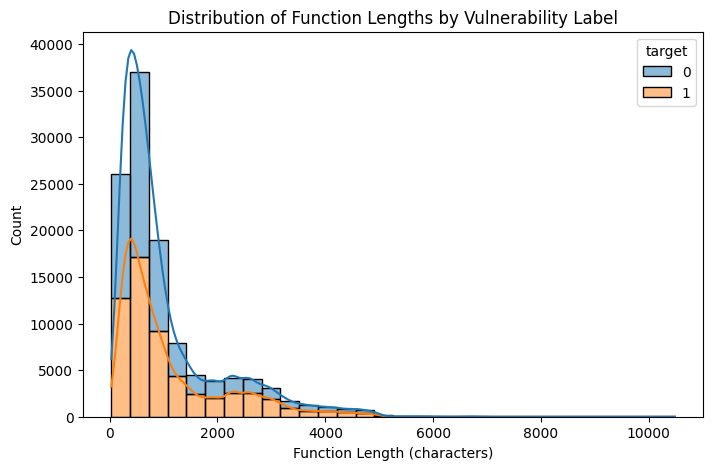

In [72]:
df_test["function_length"] = df_test["func"].apply(lambda x: len(str(x)))

plt.figure(figsize=(8, 5))
sns.histplot(df_test, x="function_length", hue="target", bins=30, kde=True, multiple="stack")

plt.xlabel("Function Length (characters)")
plt.ylabel("Count")
plt.title("Distribution of Function Lengths by Vulnerability Label")

plt.show()

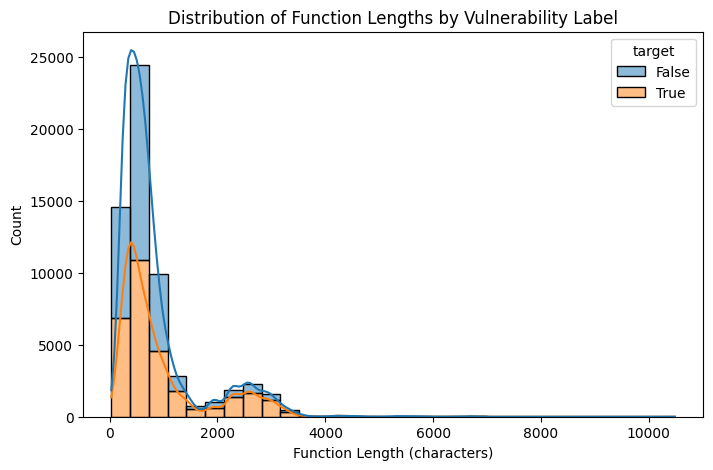

In [71]:
df_test_juliet_subset["function_length"] = df_test_juliet_subset["func"].apply(lambda x: len(str(x)))

plt.figure(figsize=(8, 5))
sns.histplot(df_test_juliet_subset, x="function_length", hue="target", bins=30, kde=True, multiple="stack")

plt.xlabel("Function Length (characters)")
plt.ylabel("Count")
plt.title("Distribution of Function Lengths by Vulnerability Label")

plt.show()

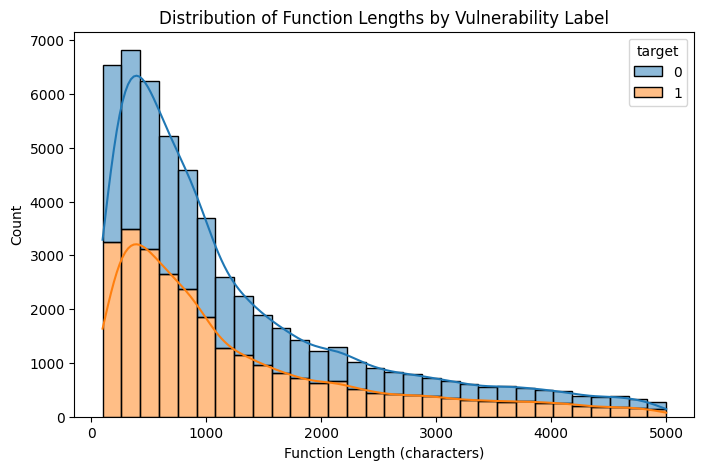

In [70]:
df_test_natural_subset["function_length"] = df_test_natural_subset["func"].apply(lambda x: len(str(x)))

plt.figure(figsize=(8, 5))
sns.histplot(df_test_natural_subset, x="function_length", hue="target", bins=30, kde=True, multiple="stack")

plt.xlabel("Function Length (characters)")
plt.ylabel("Count")
plt.title("Distribution of Function Lengths by Vulnerability Label")

plt.show()

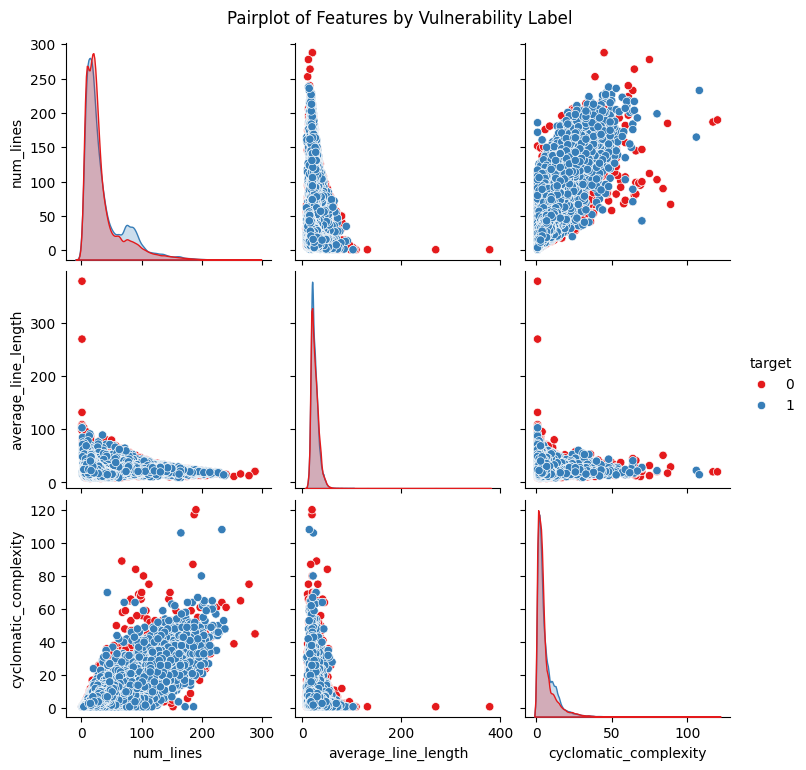

In [79]:
sns.pairplot(df_test_features[['num_lines', 'average_line_length', 'cyclomatic_complexity', 'target']], hue='target', palette="Set1")
plt.suptitle("Pairplot of Features by Vulnerability Label", y=1.02)
plt.show()